# Intensity Graded FFT Animation with QPSK

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import math
from IPython.display import HTML, Image

In [2]:
#Test QPSK Signal
num_symbols = 256*10240
sps = 2

x_int = np.random.randint(0, 4, num_symbols) # 0 to 3

x_int = np.repeat(x_int, sps, axis=0)

x_degrees = x_int*360/4.0 + 45 # 45, 135, 225, 315 degrees
x_radians = x_degrees*np.pi/180.0 # sin() and cos() takes in radians
x_symbols = np.cos(x_radians) + 1j*np.sin(x_radians) # this produces our QPSK complex symbols

# Create our raised-cosine filter
num_taps = 101
beta = 0.35
Ts = sps # Assume sample rate is 1 Hz, so sample period is 1, so *symbol* period is 8
t = np.arange(-51, 52) # remember it's not inclusive of final number
h = np.sinc(t/Ts) * np.cos(np.pi*beta*t/Ts) / (1 - (2*beta*t/Ts)**2)

# Filter our signal, in order to apply the pulse shaping
x_shaped = np.convolve(x_symbols, h)

n = (np.random.randn(len(x_shaped)) + 1j*np.random.randn(len(x_shaped)))/np.sqrt(2) # AWGN with unity power
noise_power = 0.001
r = x_shaped + n * np.sqrt(noise_power)

samples = r

In [3]:
#Function
def fft_intensity_animate(samples: np.ndarray, fft_len: int = 256, fft_div: int = 2, mag_steps: int = 100):
    
    num_ffts = math.floor(len(samples)/fft_len)
    
    fft_array = []
    for i in range(num_ffts):
        temp = np.fft.fftshift(np.fft.fft(samples[i*fft_len:(i+1)*fft_len]))
        temp_mag = 20.0 * np.log10(np.abs(temp))
        fft_array.append(temp_mag)
        
    max_mag = np.amax(fft_array)
    min_mag = np.abs(np.amin(fft_array))
    
    norm_fft_array = fft_array
    for i in range(num_ffts):
        norm_fft_array[i] = (fft_array[i]+min_mag)/(max_mag+min_mag) 
        
    return(norm_fft_array)

# Animation

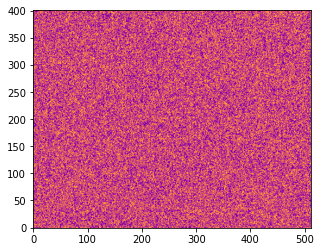

In [4]:
#Setup Animation data

#parameters
fft_len = 1024
fft_div = 2
mag_steps = 400

#animation place holder
fig = plt.figure()
zeros = np.zeros((mag_steps+1, int(fft_len/fft_div)), dtype=int)
a = np.random.random((mag_steps+1,int(fft_len/fft_div)))
im = plt.imshow(a, origin='lower', cmap='plasma', interpolation='bilinear')

#compute ffts for display
norm_fft_array = fft_intensity_animate(samples, fft_len, fft_div, mag_steps)

In [5]:
#Run Animation

#anumation init function
def init():
    zeros = np.zeros((mag_steps+1, int(fft_len/fft_div)), dtype=int)
    a = zeros
    im.set_data(np.random.random((mag_steps+1,int(fft_len/fft_div))))
    return[im]

#animate function that interates over fft data
def animate(i): 
    mag_step = 1/mag_steps
    
    if i == 0:
        hitmap_array = im.get_array()*np.exp(-10)
        
    else:
        hitmap_array = im.get_array()*np.exp(-0.04)

    for m in range(fft_len):
        hit_mag = int(norm_fft_array[i][m]/mag_step)
        hitmap_array[hit_mag][int(m/fft_div)] = hitmap_array[hit_mag][int(m/fft_div)] + .5

    #hitmap_array_db = 10.0 * np.log10(hitmap_array) 
    
    im.set_array(hitmap_array)
    return [im]

#compute animation
anim = FuncAnimation(fig, animate, init_func=init,
                               frames=1000, interval=1, blit=True)

# Save Animation

In [6]:
anim.save('fft_qpsk_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

## Optional GIF Animation

In [7]:
#anim.save('fft_animation.gif', fps=30, writer='pillow')
#Image(url='fft_animation.gif')